In [16]:
%cd '/home/naodell/work/CMS/amumu'
%matplotlib notebook

from __future__ import division
    
import sys
from timeit import default_timer as timer
from itertools import product

import numpy as np
from numpy.polynomial.legendre import legval
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from scipy.special import erf 
from scipy.stats import chi2, norm, gamma, multivariate_normal
from scipy import integrate
from lmfit import Parameter, Parameters 
    
from nllfitter import Model, NLLFitter
import nllfitter.fit_tools as ft
import nllfitter.plot_tools as pt

/home/naodell/work/CMS/amumu


In [17]:
def bg_pdf(x, a):
    '''
    Legendre polynomial times a gamma distribution background pdf
    '''
    bg_fx = lambda z: legval(ft.scale_data(z, xmin=12, xmax=70), [0.5, a[0], a[1]])*2/(70 - 12)
    bg_fy = lambda z: gamma.pdf(z, a=a[2], loc=a[3], scale=a[4])
    bg = bg_fx(x[0])*bg_fy(x[1])
    return bg
    
def sig_pdf(x, a, normalize=True):
    '''
    2D Legendre polynomial plus a bivariate Gaussian.
    '''
    bg  = bg_pdf(x, a[5:])
    
    sig_fx = lambda z: ft.voigt(z, [a[1], a[2], 0.45])
    sig_fy = lambda z: norm.pdf(z, a[3], a[4])
    sig = sig_fx(x[0])*sig_fy(x[1])

    if normalize: 
        sig_norm = 1
        sig_norm *= integrate.quad(sig_fx, 12, 70)[0]
        #sig_norm *= integrate.quad(sig_fy, 50, 500)[0]
    else:
        sig_norm = 1.

    return (1 - a[0])*bg + a[0]*sig/sig_norm

In [18]:
### Configuration
pt.set_new_tdr()
use_official = False
ntuple_dir  = 'data/flatuples/mumu_2012'
selection   = ('mumu', 'combined')
period      = 2012
model       = 'Gaussian'
output_path = 'plots/fits/{0}_{1}'.format(selection[0], period)
ext         = 'png'

datasets    = ['muon_2012A', 'muon_2012B', 'muon_2012C', 'muon_2012D']
#datasets    = ['ttbar_lep', 'ttbar_lep', 'zjets_m-50', 'zjets_m-10to50', 'bprime_xb']
features    = ['dilepton_mass', 'dilepton_b_mass']#, 'dilepton_pt_over_m']

### Define the selction criteria
cuts        = '(\
                lepton1_pt > 25 and abs(lepton1_eta) < 2.1\
                and lepton2_pt > 25 and abs(lepton2_eta) < 2.1\
                and lepton1_q != lepton2_q\
                and n_bjets == 1\
                and 12 < dilepton_mass < 70\
               )'

if selection[1] == '1b1f':
    cuts += ' and n_fwdjets > 0 and n_jets == 0'
elif selection[1] == '1b1c':
    cuts += ' and n_fwdjets == 0 and n_jets == 1 \
              and four_body_delta_phi > 2.5 and met_mag < 40'
elif selection[1] == 'combined':
    cuts += ' and ((n_fwdjets > 0 and n_jets == 0) \
              or (n_fwdjets == 0 and n_jets == 1 \
              and four_body_delta_phi > 2.5 and met_mag < 40))'
pt.make_directory(output_path, clear=False)


In [19]:
if use_official:
    if selection[1] == 'combined':
        df_1b1f = pd.read_csv('data/fit/events_1b1f_olga.txt')
        df_1b1c = pd.read_csv('data/fit/events_1b1c_olga.txt')
        df_data = df_1b1f.append(df_1b1c)
    else:
        df_data = pd.read_csv('data/fit/events_{0}_olga.txt'.format(selection[1]))
    data = df_data[features]
    data = data.values.transpose()
else:
    data_manager = pt.DataManager(input_dir     = ntuple_dir,
                                  dataset_names = datasets,
                                  period        = 2012,
                                  selection     = selection[0],
                                  cuts          = cuts
                                 )
    df_data = data_manager.get_dataframe('data')
    data = df_data[features]
    data = data.values.transpose()


Loading dataframes: 100%|███████████████| 4.00/4.00 [00:11<00:00, 2.77s/it]


In [20]:
### Define bg model and carry out fit ###
bg_params = Parameters()
bg_params.add_many(
                   ('a1'    , 0.  , True , None , None , None),
                   ('a2'    , 0.  , True , None , None , None),
                   ('k'     , 2.  , True , 1.   , None , None),
                   ('x0'    , 50. , True , 20   , 60  , None),
                   ('theta' , 30. , True , 0    , None , None),
                  )

bg_model  = Model(bg_pdf, bg_params)
bg_fitter = NLLFitter(bg_model, min_algo='SLSQP')
bg_result = bg_fitter.fit(data, calculate_corr=True)

### Define bg+sig model and carry out fit ###
sig_params = Parameters()
sig_params.add_many(
                    ('A'     , 0.01 , True , 0.0  , 1.   , None),
                    ('mu1'   , 30.  , True , 20.  , 40.  , None),
                    ('gamma' , 1.   , True , 0.45 , 3.   , None),
                    ('mu2'   , 150. , True , 120. , 180. , None),
                    ('sigma' , 5.   , True , 1.   , 25.  , None),
                   )
#for n,p in bg_params.iteritems():
#    p.vary = False
sig_params += bg_params.copy()
sig_model  = Model(sig_pdf, sig_params)
sig_fitter = NLLFitter(sig_model)
sig_result = sig_fitter.fit(data, calculate_corr=True)

Fit finished with status: 0
[[Variables]]
    a1:      0.13951890 +/- 0.032098 (23.01%) (init= 0)
    a2:      0.11737583 +/- 0.040812 (34.77%) (init= 0)
    k:       3.80466652 +/- 0.252978 (6.65%) (init= 2)
    x0:      48.6794331 +/- 2.318401 (4.76%) (init= 50)
    theta:   33.7927262 +/- 1.988960 (5.89%) (init= 30)

[[Correlation matrix]]
[[  1.000e+00   3.490e-02   1.237e-10  -5.667e-11  -1.360e-10]
 [  3.490e-02   1.000e+00  -2.878e-10   2.816e-10   2.565e-10]
 [  1.237e-10  -2.878e-10   1.000e+00  -6.772e-01  -9.222e-01]
 [ -5.667e-11   2.816e-10  -6.772e-01   1.000e+00   4.586e-01]
 [ -1.360e-10   2.565e-10  -9.222e-01   4.586e-01   1.000e+00]] 

Fit finished with status: 0
[[Variables]]
    A:       0.05708368 +/- 0.014541 (25.47%) (init= 0.01)
    mu1:     29.1336722 +/- 0.354287 (1.22%) (init= 30)
    gamma:   2.29104477 +/- 1.007418 (43.97%) (init= 1)
    mu2:     157.942786 +/- 3.408862 (2.16%) (init= 150)
    sigma:   14.0937465 +/- 3.119549 (22.13%) (init= 5)
    a1:    

In [21]:
### Calculate the likelihood ration between the background and signal model
### given the data and optimized parameters
q_max = 2*(bg_model.calc_nll(data) - sig_model.calc_nll(data))
p_value = 0.5*chi2.sf(q_max, 1)
z_score = -norm.ppf(p_value)
print 'q       = {0:.3f}'.format(q_max)
print 'p_local = {0:.3e}'.format(p_value)
print 'z_local = {0}'.format(z_score)

q       = 42.249
p_local = 4.018e-11
z_local = 6.49992224346


In [22]:
### Conditional distributions and projections ###
mu1            = sig_params['mu1'].value
mu2            = sig_params['mu2'].value
gam            = sig_params['gamma'].value
sig            = sig_params['sigma'].value
mask_mumu_sig  = (data[0] < mu1-gam) | (data[0] > mu1+gam)
mask_mumub_sig = (data[1] < mu2-2*sig) | (data[1] > mu2+2*sig)

### mumub signal in mumu
f_sig = lambda xint, z: sig_pdf([z, xint], sig_result.x)
f_bg  = lambda xint, z: bg_pdf([z, xint], sig_result.x[5:])
x     = np.linspace(12, 70, 116)

y_sig1 = np.array([integrate.quad(f_sig, 0, mu2-2*sig, args = (xx))[0] for xx in x])
y_bg1  = np.array([integrate.quad(f_bg, 0, mu2-2*sig, args = (xx))[0] for xx in x])
y_sig2 = np.array([integrate.quad(f_sig, mu2-2*sig, mu2+2*sig, args = (xx))[0] for xx in x])
y_bg2  = np.array([integrate.quad(f_bg, mu2-2*sig, mu2+2*sig, args = (xx))[0] for xx in x])
y_sig3 = np.array([integrate.quad(f_sig, mu2+2*sig, 1000, args = (xx))[0] for xx in x])
y_bg3  = np.array([integrate.quad(f_bg, mu2+2*sig, 1000, args = (xx))[0] for xx in x])

<IPython.core.display.Javascript object>


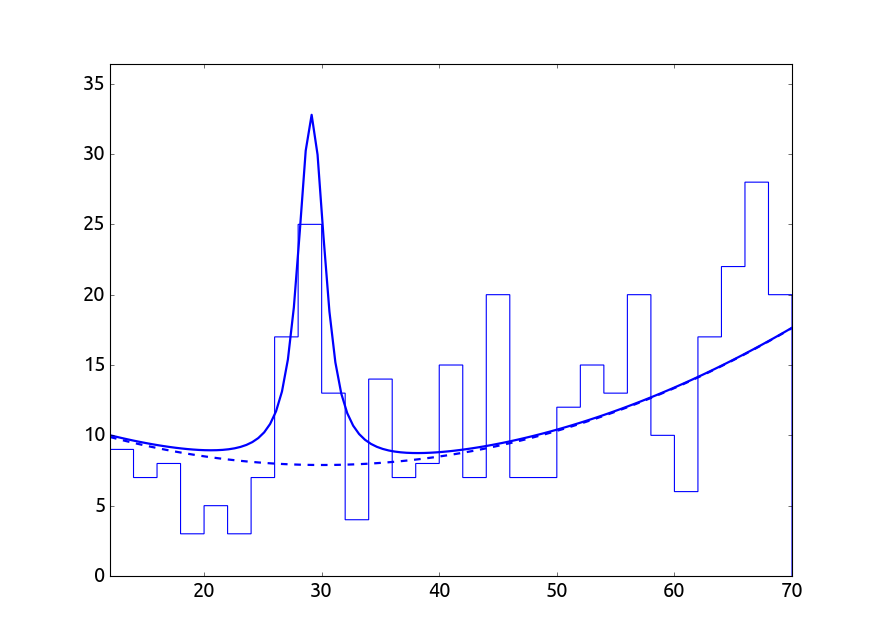

In [85]:
data_masked = data[0][mask_mumub_sig==False]
scale = 2*data_masked.size/(0.5*y_sig2.sum())
y_bg = (1 - sig_result.x[0])*scale*y_bg2
y_sig = scale*y_sig2

hist, bins, _ = plt.hist(data_masked, bins=29, range=(12, 70), histtype='step')
plt.plot(x, y_bg, 'b--', linewidth=2.)
plt.plot(x, y_sig, 'b-', linewidth=2.)
plt.xlim((12, 70))
plt.ylim((0, 1.3*np.max(hist)))
plt.show() 

In [1]:
data_masked = data[0][mask_mumub_sig]
scale = 2*data_masked.size/(0.5*np.sum(y_sig1 + y_sig3))
y_bg  = scale*(1 - sig_result.x[0])*(y_bg1+y_bg3)
y_sig = scale*(y_sig1+y_sig3)

hist, bins, _ = plt.hist(data_masked, bins=29, range=(12, 70), histtype='step')
plt.plot(x, y_bg, 'b--', linewidth=2.)
plt.plot(x, y_sig, 'b-', linewidth=2.)
plt.xlim((12, 70))
plt.ylim((0, 1.3*np.max(hist)))
plt.show() 

NameError: name 'data' is not defined

In [100]:
### mumu signal in mumub
f_sig = lambda xint, z: sig_pdf([xint, z], sig_result.x)
f_bg  = lambda xint, z: bg_pdf([xint, z], sig_result.x[5:])
x     = np.linspace(0, 400, 400)

y_sig1 = np.array([integrate.quad(f_sig, 12, mu1-gam, args = (xx))[0] for xx in x])
y_bg1  = np.array([integrate.quad(f_bg, 12, mu1-gam, args = (xx))[0] for xx in x])
y_sig2 = np.array([integrate.quad(f_sig, mu1-gam, mu1+gam, args = (xx))[0] for xx in x])
y_bg2  = np.array([integrate.quad(f_bg, mu1-gam, mu1+gam, args = (xx))[0] for xx in x])
y_sig3 = np.array([integrate.quad(f_sig, mu1+gam, 70, args = (xx))[0] for xx in x])
y_bg3  = np.array([integrate.quad(f_bg, mu1+gam, 70, args = (xx))[0] for xx in x])

<IPython.core.display.Javascript object>


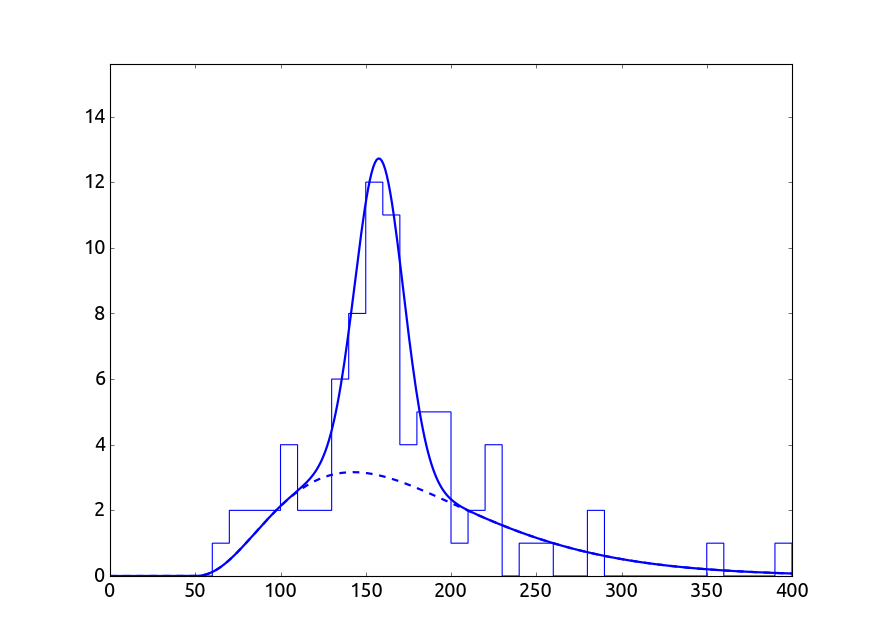

In [103]:
data_masked = data[1][mask_mumu_sig==False]
scale = 10*data_masked.size/y_sig2.sum()
y_bg = (1 - sig_result.x[0])*scale*y_bg2
y_sig = scale*y_sig2

hist, bins, _ = plt.hist(data_masked, bins=40, range=(0, 400), histtype='step')
plt.plot(x, y_bg, 'b--', linewidth=2.)
plt.plot(x, y_sig, 'b-', linewidth=2.)
plt.xlim((0, 400))
plt.ylim((0, 1.3*np.max(hist)))
plt.show() 

<IPython.core.display.Javascript object>


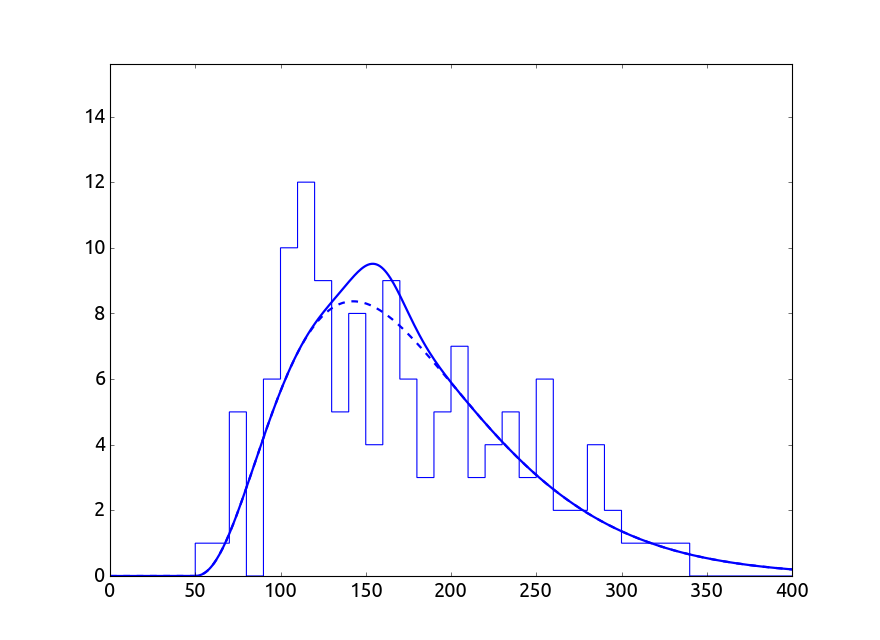

In [113]:
#data_masked = data[1][mask_mumu_sig]
data_masked = data[1][data[0]<24]

scale = 10*data_masked.size/np.sum(y_sig1)# + y_sig3)
y_bg  = scale*(1 - sig_result.x[0])*(y_bg1)#+y_bg3)
y_sig = scale*(y_sig1)#+y_sig3)

hist, bins, _ = plt.hist(data_masked, bins=40, range=(0, 400), histtype='step')
plt.plot(x, y_bg, 'b--', linewidth=2.)
plt.plot(x, y_sig, 'b-', linewidth=2.)
plt.xlim((0, 400))
plt.ylim((0, 1.3*np.max(hist)))
plt.show() 
%qtconsole